In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import jit

sns.set_style("ticks")
sns.set_context("talk")

colors = sns.color_palette()

In [2]:
# Parameters discretization
L = 1001
DELTA = 0.1
TAU = 0.001
M = 50000
params = L, DELTA, TAU, M

# Real space grid
x = np.arange(0, L * DELTA, DELTA)

# No barrier potential
V_no_barrier = np.zeros_like(x)

# Barrier potential
range_barrier = (50, 50.5)
mask_barrier = (x >= range_barrier[0]) & (x <= range_barrier[1])
V_barrier = np.zeros_like(x)
V_barrier[mask_barrier] = 2

# Parameters initial condition
SIGMA = 3
X_0 = 20
Q = 1

In [3]:
# Initial condition
phi0 = (2 * np.pi * SIGMA ** 2) ** (-1 / 4) * np.exp(1j * Q * (x-X_0)) * np.exp(- (x - X_0) ** 2 / (4 * SIGMA ** 2))

In [4]:
@jit(nopython=True)
def evolve(phi0, V, params, times_to_return):
    """
    Product formula approach to time evolve the initial condition phi0 under the potential V
    using the parameters params.
    Return the wavefunction at the times specified in times_to_return.
    """
    L, DELTA, TAU, M = params

    # Convert times to return into timesteps
    i_to_return = [int(time / TAU) for time in times_to_return]

    # Potential energy matrix diagonal
    V = 1 / DELTA**2 + V

    # Submatrix for kinetic energy matrix exponential
    a = TAU / (4 * DELTA**2)
    submatrix = np.array([[np.cos(a), 1j * np.sin(a)], [1j * np.sin(a), np.cos(a)]])

    phi = phi0.copy()
    phis_to_return = []

    # Loop over timesteps
    for i in range(1, M + 1):

        # Multiplication by K_1 matrix exponential
        for j in range(0, L - 1, 2):
            phi[j : j + 2] = submatrix @ phi[j : j + 2]

        # Multiplication by K_2 matrix exponential
        for j in range(1, L, 2):
            phi[j : j + 2] = submatrix @ phi[j : j + 2]

        # Multiplication by V matrix exponential
        phi = np.exp(-1j * V * TAU) * phi

        # Multiplication by K_2 matrix exponential
        for j in range(1, L, 2):
            phi[j : j + 2] = submatrix @ phi[j : j + 2]

        # Multiplication by K_1 matrix exponential
        for j in range(0, L - 1, 2):
            phi[j : j + 2] = submatrix @ phi[j : j + 2]

        # Return the wavefunction at the times specified in times_to_return
        if i in i_to_return:
            phis_to_return.append(phi.copy())

    return phis_to_return

### No barrier

In [5]:
# Time evolution snapshots
times = [5, 40, 45, 50]
phis = evolve(phi0, V_no_barrier, params, times)

# Add initial condition to the snapshots
times = [0] + [5, 40, 45, 50]
phis = [phi0] + phis

C:\Users\lpaiv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'times_to_return' of function 'evolve'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_752\2742573901.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


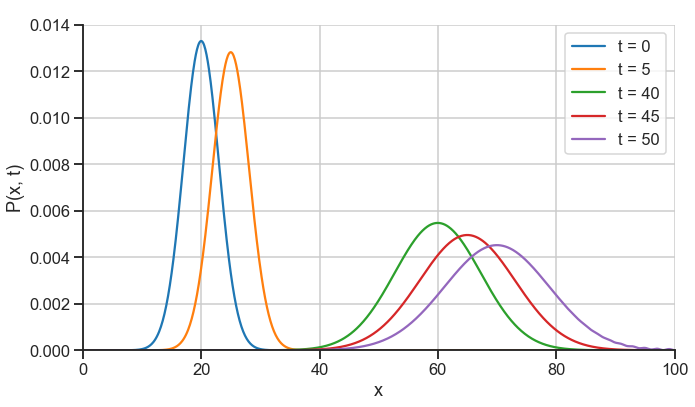

In [6]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Dummy text to add white space
ax.text(50.25, 0.014, "Barrier", fontsize=18, ha="center", va="bottom", color="white")

for i, (time, phi) in enumerate(zip(times, phis)):
    ax.plot(x, np.abs(phi) ** 2 * DELTA, label=f"t = {time}", color=colors[i])

ax.set_xlabel("x")
ax.set_ylabel("P(x, t)")

ax.set_xlim(0, 100)
ax.set_ylim(0, 0.014)

ax.grid()
plt.legend()

plt.tight_layout()
sns.despine()
plt.savefig("figures/CP_exercise_8_no_barrier.pdf")
plt.show()

### Barrier

In [7]:
# Time evolution snapshots
times = [5, 40, 45, 50]
phis = evolve(phi0, V_barrier, params, times)

# Add initial condition to the snapshots
times = [0] + [5, 40, 45, 50]
phis = [phi0] + phis

In [8]:
# Compute total probability for particle behind the barrier for each snapshot
probability_tunneled = [np.sum(np.abs(phi[x > range_barrier[1]]) ** 2 * DELTA) for phi in phis]

# Take the maximum value as normalization for probabilities behind the barrier
normalization = max(probability_tunneled)

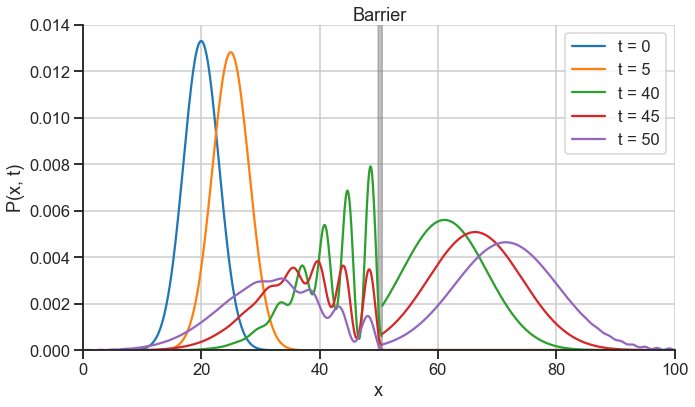

In [9]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.fill_between(x, V_barrier, color="gray", alpha=0.5)
ax.text(50.25, 0.014, "Barrier", fontsize=18, ha="center", va="bottom")

for i, (time, phi) in enumerate(zip(times, phis)):
    mask_tunneled = x > range_barrier[1]	
    
    # Plot the probabilities for the particle in front of the barrier
    ax.plot(x[~mask_tunneled], np.abs(phi[~mask_tunneled]) ** 2 * DELTA, label=f"t = {time}", color=colors[i])
    
    # Plot the normalized probabilities for the particle behind the barrier
    ax.plot(x[mask_tunneled], np.abs(phi[mask_tunneled]) ** 2 * DELTA / normalization, color=colors[i])

ax.set_xlabel("x")
ax.set_ylabel("P(x, t)")

ax.set_xlim(0, 100)
ax.set_ylim(0, 0.014)

ax.grid()
plt.legend()

plt.tight_layout()
sns.despine()
plt.savefig("figures/CP_exercise_8_barrier.pdf")
plt.show()